In [15]:
import sys
!{sys.executable} -m pip install -q tensorflow-addons


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Why Transformers need to applied on patches and not pixels
* If we use self-attention mechanism on image data, then each pixel in an image would need to attend and be compared to every other pixel. 
* The problem is, if we increase the pixel value by one, then the computational cost would increase quadratically. 
* This is simply not feasible if we have an image with a reasonably large resolution.

1) Patching can be done by spliting the image into (no. of patches X (patch_size^2. channel)). Then apply linear layer to embed.
2) Send it to a convolution layer with kernel_size and stride = patch_size. Then we flatten the output


In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
print(f"x_train: {x_train.shape} - y_train: {y_train.shape}")
print(f"x_test: {x_test.shape} - y_test: {y_test.shape}")

x_train: (50000, 32, 32, 3) - y_train: (50000, 1)
x_test: (10000, 32, 32, 3) - y_test: (10000, 1)


In [26]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72
patch_size = 6  
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2,projection_dim,] 
transformer_layers = 8
mlp_head_units = [2048, 1024]

### Data Augmentation

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_addons as tfa

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(72, 72),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

In [14]:
print(data_augmentation.layers[0].variance)
print(data_augmentation.layers[0].mean)

tf.Tensor([[[[3968.1458 3855.0076 4449.5435]]]], shape=(1, 1, 1, 3), dtype=float32)
tf.Tensor([[[[125.306915 122.95039  113.86539 ]]]], shape=(1, 1, 1, 3), dtype=float32)


(-0.5, 31.5, 31.5, -0.5)

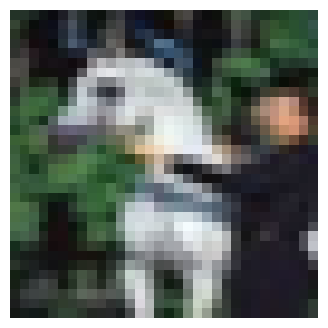

In [15]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

### BUILD THE NETWORK

In [17]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [18]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
 
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [24]:
# n = int(np.sqrt(x_train.shape[1]))
# plt.figure(figsize=(4, 4))
# for i, patch in enumerate(x_train[0]):
#     ax = plt.subplot(n, n, i + 1)
#     patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
#     plt.imshow(patch_img.numpy().astype("uint8"))
#     plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
 
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [25]:
def create_vit_classifier(input_shape):
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    print(augmented.shape)
    patches = Patches(patch_size)(augmented)
    print(patches)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches) # 
 
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])
 
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(10)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

### Compiling and training

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
 
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
       keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
       keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"), ],)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,)

In [ ]:
_, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")